# Assignment Work

---

### Let us begin by importing the essential Python Libraries.

> NumPy : Library for Numeric Computations in Python <br/> 
> Pandas : Library for Data Acquisition and Preparation <br/>
> Matplotlib : Low-level library for Data Visualization<br /> 
> Seaborn : Higher-level library for Data Visualization<br />
> Linear_model : Library to plot Linear Regression Model<br />
> Model_selection : Split the dataset into training and testing dataset<br />
> Metrics: Calculation of Mean Square Error & R^2<br />
> RandomForestRegressor: Library to plot Random Forest Regressor<br />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sb
sb.set()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---

## Setup : Import the Dataset

Problem Statement : Understanding the Freight Value of eCommerce<br />
Freight Rate is the price in which goods are being delivered from one location to the other. The pricing depends on the form of cargo, mode of transport, weight of the cargo and the distance taken to delivery destination.


Source: https://www.kaggle.com/olistbr/brazilian-ecommerce

There are 9 datasets from the website which was used:

> 1) olist_sellers_dataset.csv <br /> 
> 2) olist_customers_dataset.csv <br />
> 3) list_order_reviews_dataset.csv <br />
> 4) olist_order_items_dataset.csv <br />
> 5) olist_products_dataset.csv <br />
> 6) product_category_name_translation.csv <br />
> 7) olist_orders_dataset.csv <br />
> 8) olist_order_payments_dataset.csv <br />
> 9) olist_geolocation_dataset.csv <br />

The following steps is to merge the dataset into a dataframe. In order to concatenate the 9 total dataset, the following steps:
   > 1) Firstly, we convert the name for product category from Portugese to English. <br />
   > 2) For Dataframe `df_order_items_w_product_cat`, we merge the dataset for `order_items` and `products` together based on `Product_ID`. <br />
   > 3) For Dataframe `df_order_cat_w_sellers`, we merge the dataset for `df_order_items_w_product_cat` and `sellers` together based on `Seller_ID`. <br />
   > 4) For Dataframe `df_order_w_customer`, we merge the dataset for `orders` and `items` together based on `Customer_ID`. <br />
   > 5) For Dataframe `df_geolocation`, the columns `geolocation_zip_code_prefix` is duplicated in order to receive information for `df_order_cat_w_sellers` and `df_order_w_customer` address.<br />
   > 6) The final dataframe is then merged together.

## Calculations : Defined Functions

There are 2 functions which are implemented and added into the dataframe:

> 1) Haversine Distance
> 2) Package Size

The Haversine function is mainly used in navigations in order to calculate the distance between 2 places. The distance between 2 points is calculated based on the given longitutde and latitude. 

In order to calculate the package size (cm^3) of each product, the formula is calculated by: product length * product width * product height

In [2]:
def merged_dataframe():
    df_sellers             = pd.read_csv('olist_sellers_dataset.csv')
    df_customers           = pd.read_csv('olist_customers_dataset.csv')
    df_reviews             = pd.read_csv('olist_order_reviews_dataset.csv')
    df_order_items         = pd.read_csv('olist_order_items_dataset.csv')
    df_products            = pd.read_csv('olist_products_dataset.csv')
    df_catname_translation = pd.read_csv('product_category_name_translation.csv')
    df_orders              = pd.read_csv('olist_orders_dataset.csv')
    df_order_payments      = pd.read_csv('olist_order_payments_dataset.csv')
    df_geolocation         = pd.read_csv('olist_geolocation_dataset.csv')

    catname_translation = df_catname_translation.set_index('product_category_name')['product_category_name_english'].to_dict()


    df_products = df_products.replace({ 'product_category_name' : catname_translation })
    
    df_order_items_w_product_cat = pd.merge(df_order_items,
                                            df_products[['product_id', 'product_category_name','product_weight_g','product_length_cm','product_height_cm','product_width_cm']],
                                            on='product_id',
                                            how='left')
    
    df_order_cat_w_sellers = pd.merge(df_order_items_w_product_cat,
                                      df_sellers[['seller_id','seller_zip_code_prefix','seller_city', 'seller_state']],
                                      on='seller_id',
                                      how='left')
    
    df_order_w_customer = pd.merge(df_orders,
                        df_customers[['customer_id','customer_zip_code_prefix', 'customer_city', 'customer_state']],
                        on='customer_id',
                        how = 'left')
    
    df_geolocation = df_geolocation[~df_geolocation['geolocation_zip_code_prefix'].duplicated()]
    
    df_order_cat_w_sellers = pd.merge(df_order_cat_w_sellers,df_geolocation,
                                    left_on = "seller_zip_code_prefix",
                                    right_on = "geolocation_zip_code_prefix",
                                    how = "left").drop(columns=['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])
    
    df_order_w_customer = pd.merge(df_order_w_customer,df_geolocation,
                                    left_on = "customer_zip_code_prefix",
                                    right_on = "geolocation_zip_code_prefix",
                                    how = "left").drop(columns=['geolocation_zip_code_prefix','geolocation_city','geolocation_state'])
    
    df = pd.merge(df_order_w_customer,df_order_cat_w_sellers,
                     on='order_id')

    df = df.rename(columns={'geolocation_lat_x': 'customer_geolocation_lat',
                            'geolocation_lng_x': 'customer_geolocation_lng',
                            'geolocation_lat_y': 'seller_geolocation_lat',
                            'geolocation_lng_y': 'seller_geolocation_lng'})
    
    return df

def clean_data_get_distance(df):
    dataframe = df.groupby(by="order_id").nunique()
    mono_orders = pd.Series(dataframe[dataframe['seller_id'] == 1].index)
    filtered_orders = df.merge(mono_orders, how = 'inner')
    
    filtered_orders = filtered_orders.drop(columns = ["order_approved_at"])
    filtered_orders = filtered_orders.dropna()
    
    filtered_orders['distance_km'] = filtered_orders.apply(
    lambda row: haversine_distance(
        row["seller_geolocation_lng"],
        row["seller_geolocation_lat"],
        row["customer_geolocation_lng"],
        row["customer_geolocation_lat"],
    ),
    axis=1,
)
    
    return filtered_orders

def package_size(df):
    df_order_items         = pd.read_csv('olist_order_items_dataset.csv')
    df_products            = pd.read_csv('olist_products_dataset.csv')
    
    df_tmp = df_order_items[['order_id', 'product_id']].merge(df_products[['product_id', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']],
                                        on = "product_id",
                                        how = "outer")
    df_tmp.loc[:, "product_size_cm3"] = df_tmp['product_length_cm'] * df_tmp['product_width_cm'] * df_tmp['product_height_cm']
    orders_size_weight = df_tmp.groupby("order_id", as_index = False).sum()[['order_id','product_size_cm3', 'product_weight_g']]
    filtered_orders = df.merge(orders_size_weight,
                    on = 'order_id',
                    how = 'left').drop(columns=['product_weight_g_y'])
    
    filtered_orders = filtered_orders.rename(columns={'product_weight_g_x': 'product_weight_g'})
    
    return filtered_orders



# def wait_time(df):
#     time_columns = ['order_purchase_timestamp',
#                  'order_delivered_customer_date',
#                  'order_estimated_delivery_date']
#     for column in time_columns:
#         df.loc[:, column] = pd.to_datetime(df[column])
        
#     df.loc[:,"wait_time"] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

#     return df

def haversine_distance(lon1, lat1, lon2, lat2):
    from math import radians, sin, cos, asin, sqrt
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return (2 * 6371 * asin(sqrt(a)))

In [3]:
df = merged_dataframe()
df = clean_data_get_distance(df)
# #df = package_size(df)
# df = wait_time(df)

In [4]:
#df.shape
#df.head()
df.T

,0,1,2,3,4,5,7,8,9,10,...,109537,109538,109539,109540,109541,109542,109543,109544,109545,109546
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,a4591c265e18cb1dcee52889e2d8acc3,6514b8ad8028c9f2cc2374ded245783f,76c6e866289321a7c93b82b54852dc33,e69bfb5eb88e0ed6a785585b27e16dbf,e6ce16cb79ec1d90b1da9085a6118aeb,...,9115830be804184b91f5c00f6f49f92d,9115830be804184b91f5c00f6f49f92d,aa04ef5214580b06b10e2a378300db44,880675dff2150932f1601e1c07eadeeb,9c5dedf39a927c1b2549525ed64a053c,63943bddc261676b46f01ca7ac2f7bd8,83c1379a015df1e13d02aae0204711ab,11c177c8e97725db2631073c19f07b62,11c177c8e97725db2631073c19f07b62,66dea50a8b16d9b4dee7af250b4be1a5
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c,503740e9ca751ccdda7ba28e9ab8f608,9bdf08b4b3b52b5526ff42d37d47f222,f54a9f0e6b351c431402b8461ea51999,31ad1d1b63eb9962463f764d4e6e0c9d,494dded5b201313c64ed7f100595b95c,...,da2124f134f5dfbce9d06f29bdb6c308,da2124f134f5dfbce9d06f29bdb6c308,f01a6bfcc730456317e4081fe0c9940e,47cd45a6ac7b9fb16537df2ccffeb5ac,39bd1228ee8140590ac3aca26f2dfe00,1fca14ff2861355f6e5f14306ff977a7,1aa71eb042121263aafbe80c1b562c9c,b331b74b18dc79bcdf6532d51e1637c1,b331b74b18dc79bcdf6532d51e1637c1,edb027a75a1449115f6b43211ae02a24
order_status,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39,2017-07-09 21:57:05,2017-05-16 13:10:30,2017-01-23 18:29:09,2017-07-29 11:55:02,2017-05-16 19:41:10,...,2017-10-04 19:57:37,2017-10-04 19:57:37,2017-01-27 00:30:03,2017-02-23 09:05:12,2017-03-09 09:54:05,2018-02-06 12:58:58,2017-08-27 14:46:43,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-03-08 20:57:30
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,2017-07-11 14:58:04,2017-05-22 10:07:46,2017-01-26 14:16:31,2017-08-10 19:45:24,2017-05-18 11:40:40,...,2017-10-05 16:52:52,2017-10-05 16:52:52,2017-01-30 11:40:16,2017-03-01 10:22:52,2017-03-10 11:18:03,2018-02-07 23:22:42,2017-08-28 20:52:26,2018-01-12 15:35:03,2018-01-12 15:35:03,2018-03-09 22:11:59
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,2017-07-26 10:57:55,2017-05-26 12:55:51,2017-02-02 14:08:10,2017-08-16 17:14:30,2017-05-29 11:18:31,...,2017-10-20 20:25:45,2017-10-20 20:25:45,2017-02-07 13:15:25,2017-03-06 11:08:08,2017-03-17 15:08:01,2018-02-28 17:37:56,2017-09-21 11:24:17,2018-01-25 23:32:54,2018-01-25 23:32:54,2018-03-16 13:08:30
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00,2017-08-01 00:00:00,2017-06-07 00:00:00,2017-03-06 00:00:00,2017-08-23 00:00:00,2017-06-07 00:00:00,...,2017-11-07 00:00:00,2017-11-07 00:00:00,2017-03-17 00:00:00,2017-03-22 00:00:00,2017-03-28 00:00:00,2018-03-02 00:00:00,2017-09-27 00:00:00,2018-02-15 00:00:00,2018-02-15 00:00:00,2018-04-03 00:00:00
customer_zip_code_prefix,3149,47813,75265,59296,9195,86320,26525,99655,18075,20780,...,78048,78048,35502,5127,12209,11722,45920,28685,28685,83750
customer_city,sao paulo,barreiras,vianopolis,sao goncalo do amarante,santo andre,congonhinhas,nilopolis,faxinalzinho,sorocaba,rio de janeiro,...,cuiaba,cuiaba,divinopolis,sao paulo,sao jose dos campos,praia grande,nova vicosa,japuiba,japuiba,lapa
customer_state,SP,BA,GO,RN,SP,PR,RJ,RS,SP,RJ,...,MT,MT,MG,SP,SP,SP,BA,RJ,RJ,PR


In [5]:
#df.to_csv('combined.csv', index = False)
df.columns.values

array(['order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'customer_geolocation_lat', 'customer_geolocation_lng',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_weight_g', 'product_length_cm', 'product_height_cm',
       'product_width_cm', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'seller_geolocation_lat', 'seller_geolocation_lng',
       'distance_km'], dtype=object)

In [6]:
#count the unique occurance of values in columns
df['seller_state'].value_counts(ascending=True)
df['product_category_name'].value_counts(ascending=True)

security_and_services                                2
pc_gamer                                             7
fashion_childrens_clothes                            7
la_cuisine                                          12
portateis_cozinha_e_preparadores_de_alimentos       14
                                                 ...  
computers_accessories                             7401
furniture_decor                                   7715
sports_leisure                                    8219
health_beauty                                     9325
bed_bath_table                                   10265
Name: product_category_name, Length: 73, dtype: int64

In [7]:
#converting string type to datetime
for var in ['order_purchase_timestamp', 'order_delivered_customer_date','order_estimated_delivery_date']:
    df.loc[:, var] = pd.to_datetime(df[var])
    
df.loc[:,'wait_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days



In [8]:
median = np.median(df['freight_value'])
upper_quartile = np.percentile(df['freight_value'], 75)
lower_quartile = np.percentile(df['freight_value'], 25)
print("Median      \t:", median)
print("Upper Quartile \t:", upper_quartile)
print("Lower Quartile \t:", lower_quartile)

Median      	: 16.29
Upper Quartile 	: 21.15
Lower Quartile 	: 13.11


## Exploratory Data Analysis

#### Distplot of Freight Value

C:\Users\Ying Xuan\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='freight_value', ylabel='Density'>

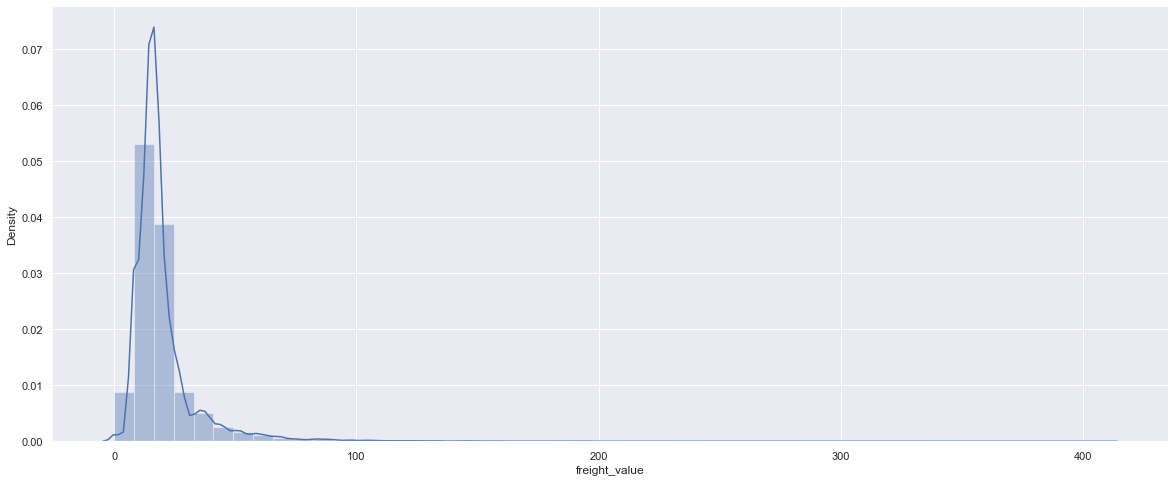

In [9]:
f = plt.figure(figsize=(20, 8))
sb.distplot(df['freight_value'])

#### KDEplot of Freight Value

<AxesSubplot:xlabel='freight_value', ylabel='Density'>

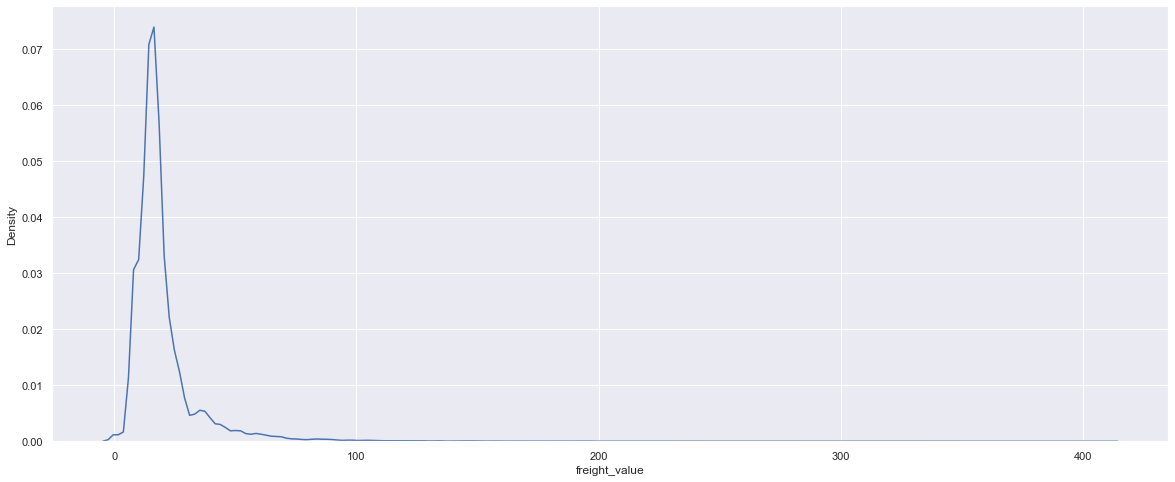

In [10]:
f = plt.figure(figsize=(20, 8))
sb.kdeplot(data=df, x="freight_value")

#### Boxplot of Freight Value

<AxesSubplot:>

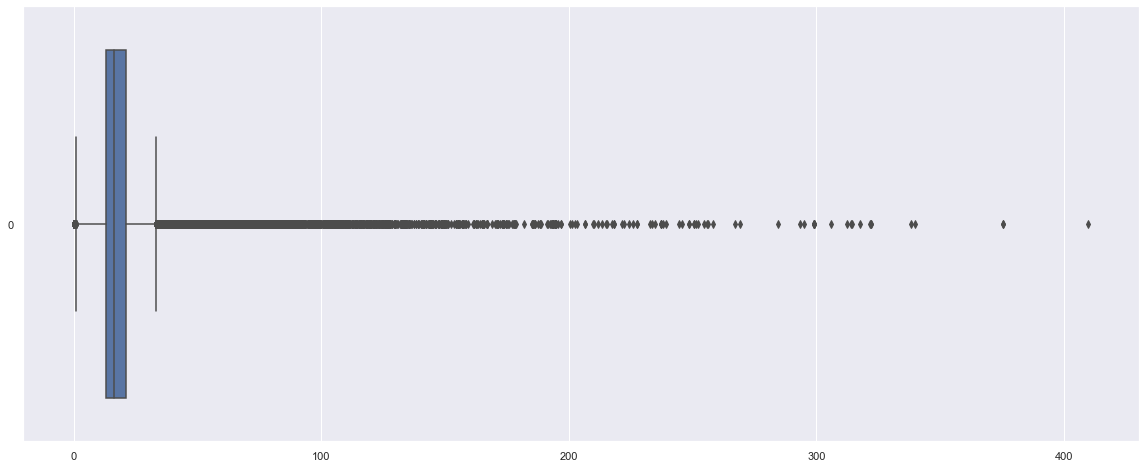

In [11]:
f = plt.figure(figsize=(20, 8))
sb.boxplot(data=df['freight_value'], orient="h")

#### Histplot of Freight Value

<AxesSubplot:xlabel='freight_value', ylabel='Count'>

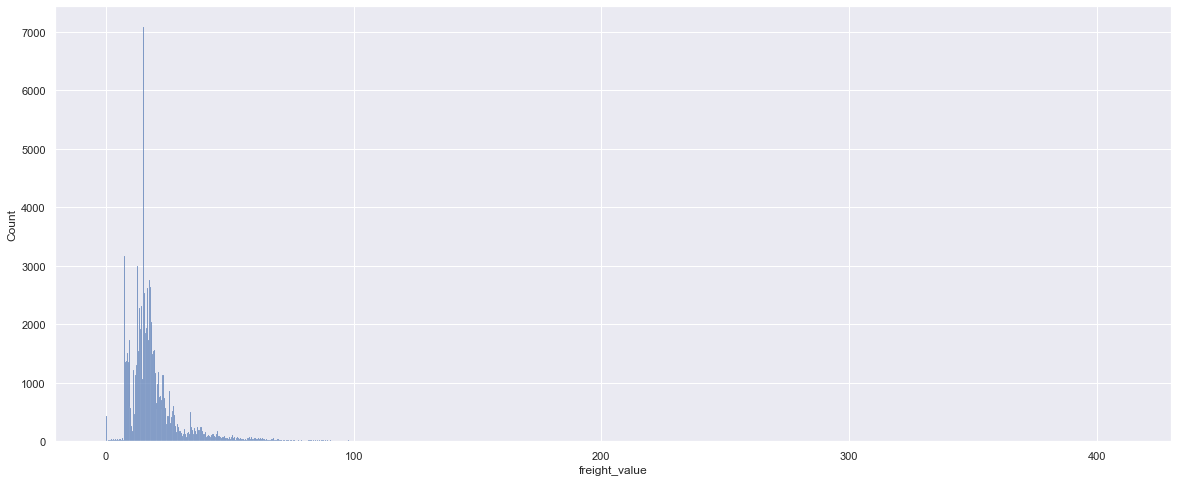

In [12]:
f = plt.figure(figsize=(20, 8))
sb.histplot(data=df['freight_value'])

#### Violinplot of Freight Value

<AxesSubplot:>

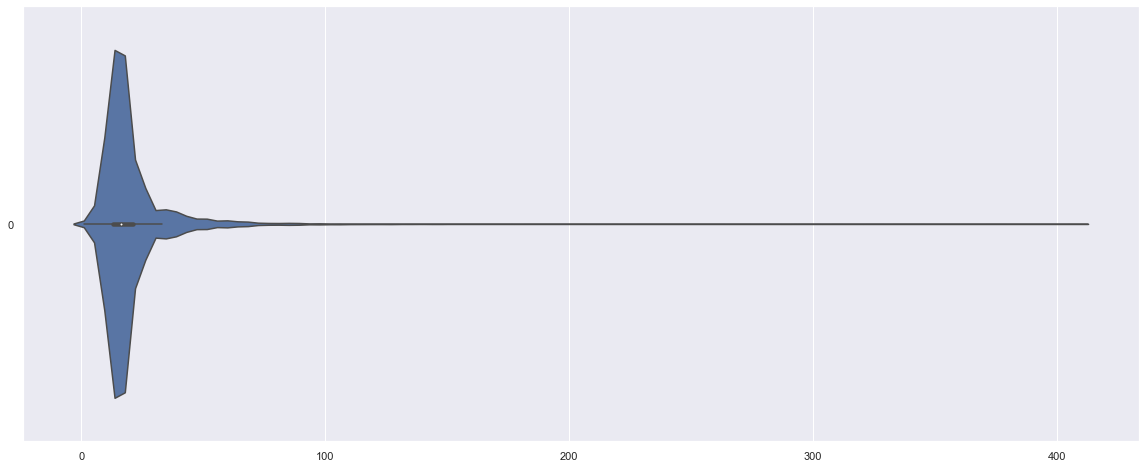

In [13]:
f = plt.figure(figsize=(20, 8))
sb.violinplot(data=df['freight_value'], orient="h")

In [14]:
df = package_size(df)
df.T

,0,1,2,3,4,5,6,7,8,9,...,105074,105075,105076,105077,105078,105079,105080,105081,105082,105083
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,a4591c265e18cb1dcee52889e2d8acc3,6514b8ad8028c9f2cc2374ded245783f,76c6e866289321a7c93b82b54852dc33,e69bfb5eb88e0ed6a785585b27e16dbf,e6ce16cb79ec1d90b1da9085a6118aeb,...,9115830be804184b91f5c00f6f49f92d,9115830be804184b91f5c00f6f49f92d,aa04ef5214580b06b10e2a378300db44,880675dff2150932f1601e1c07eadeeb,9c5dedf39a927c1b2549525ed64a053c,63943bddc261676b46f01ca7ac2f7bd8,83c1379a015df1e13d02aae0204711ab,11c177c8e97725db2631073c19f07b62,11c177c8e97725db2631073c19f07b62,66dea50a8b16d9b4dee7af250b4be1a5
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c,503740e9ca751ccdda7ba28e9ab8f608,9bdf08b4b3b52b5526ff42d37d47f222,f54a9f0e6b351c431402b8461ea51999,31ad1d1b63eb9962463f764d4e6e0c9d,494dded5b201313c64ed7f100595b95c,...,da2124f134f5dfbce9d06f29bdb6c308,da2124f134f5dfbce9d06f29bdb6c308,f01a6bfcc730456317e4081fe0c9940e,47cd45a6ac7b9fb16537df2ccffeb5ac,39bd1228ee8140590ac3aca26f2dfe00,1fca14ff2861355f6e5f14306ff977a7,1aa71eb042121263aafbe80c1b562c9c,b331b74b18dc79bcdf6532d51e1637c1,b331b74b18dc79bcdf6532d51e1637c1,edb027a75a1449115f6b43211ae02a24
order_status,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39,2017-07-09 21:57:05,2017-05-16 13:10:30,2017-01-23 18:29:09,2017-07-29 11:55:02,2017-05-16 19:41:10,...,2017-10-04 19:57:37,2017-10-04 19:57:37,2017-01-27 00:30:03,2017-02-23 09:05:12,2017-03-09 09:54:05,2018-02-06 12:58:58,2017-08-27 14:46:43,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-03-08 20:57:30
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,2017-07-11 14:58:04,2017-05-22 10:07:46,2017-01-26 14:16:31,2017-08-10 19:45:24,2017-05-18 11:40:40,...,2017-10-05 16:52:52,2017-10-05 16:52:52,2017-01-30 11:40:16,2017-03-01 10:22:52,2017-03-10 11:18:03,2018-02-07 23:22:42,2017-08-28 20:52:26,2018-01-12 15:35:03,2018-01-12 15:35:03,2018-03-09 22:11:59
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,2017-07-26 10:57:55,2017-05-26 12:55:51,2017-02-02 14:08:10,2017-08-16 17:14:30,2017-05-29 11:18:31,...,2017-10-20 20:25:45,2017-10-20 20:25:45,2017-02-07 13:15:25,2017-03-06 11:08:08,2017-03-17 15:08:01,2018-02-28 17:37:56,2017-09-21 11:24:17,2018-01-25 23:32:54,2018-01-25 23:32:54,2018-03-16 13:08:30
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00,2017-08-01 00:00:00,2017-06-07 00:00:00,2017-03-06 00:00:00,2017-08-23 00:00:00,2017-06-07 00:00:00,...,2017-11-07 00:00:00,2017-11-07 00:00:00,2017-03-17 00:00:00,2017-03-22 00:00:00,2017-03-28 00:00:00,2018-03-02 00:00:00,2017-09-27 00:00:00,2018-02-15 00:00:00,2018-02-15 00:00:00,2018-04-03 00:00:00
customer_zip_code_prefix,3149,47813,75265,59296,9195,86320,26525,99655,18075,20780,...,78048,78048,35502,5127,12209,11722,45920,28685,28685,83750
customer_city,sao paulo,barreiras,vianopolis,sao goncalo do amarante,santo andre,congonhinhas,nilopolis,faxinalzinho,sorocaba,rio de janeiro,...,cuiaba,cuiaba,divinopolis,sao paulo,sao jose dos campos,praia grande,nova vicosa,japuiba,japuiba,lapa
customer_state,SP,BA,GO,RN,SP,PR,RJ,RS,SP,RJ,...,MT,MT,MG,SP,SP,SP,BA,RJ,RJ,PR


### Heatmaps and Jointplots of:
Product weight vs Freight value <br/> 

<AxesSubplot:>

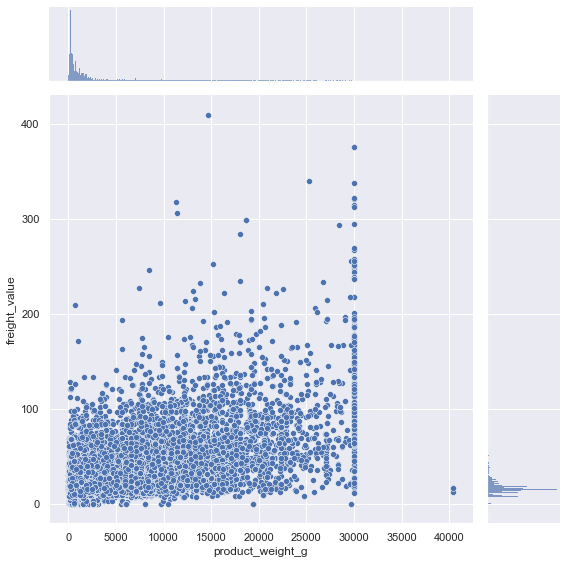

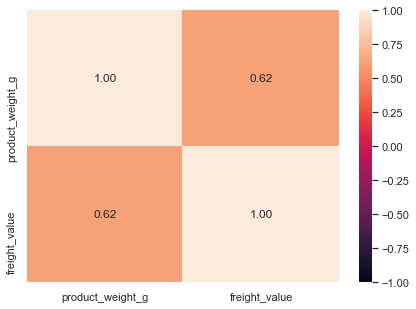

In [15]:

sb.jointplot(data = df, x = "product_weight_g", y = "freight_value", height = 8)
print()

f = plt.figure(figsize=(7, 5))
sb.heatmap((df[["product_weight_g","freight_value"]]).corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Product size vs Freight value

<AxesSubplot:>

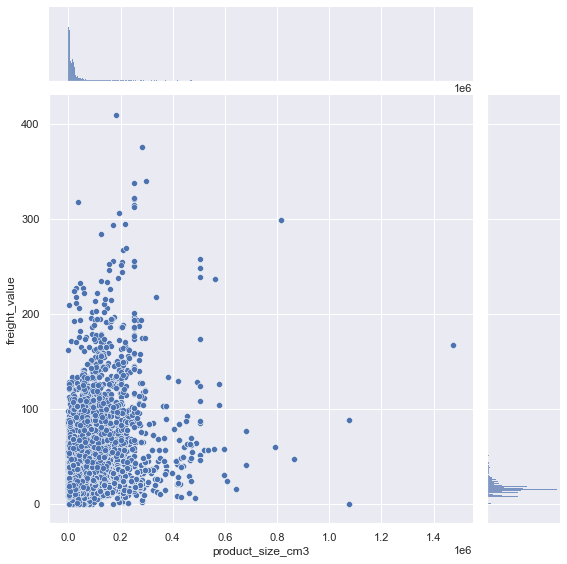

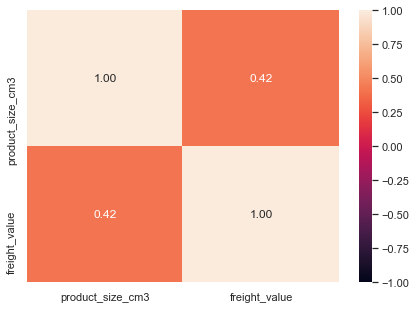

In [16]:
sb.jointplot(data = df, x = "product_size_cm3", y = "freight_value", height = 8)
print()

f = plt.figure(figsize=(7, 5))
sb.heatmap((df[["product_size_cm3","freight_value"]]).corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Product price  vs Freight value 


<AxesSubplot:>

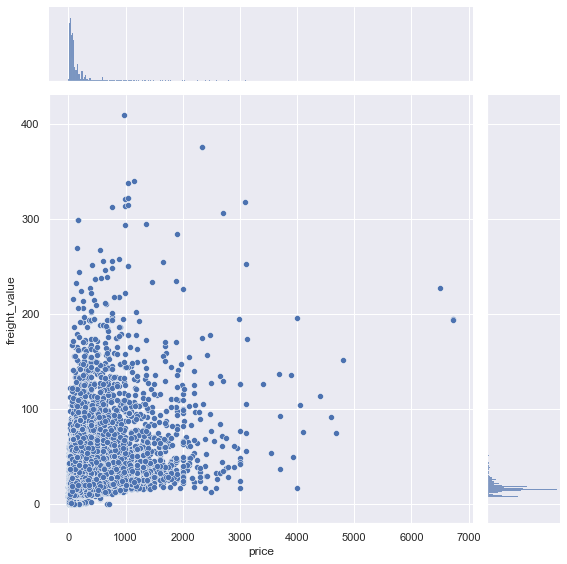

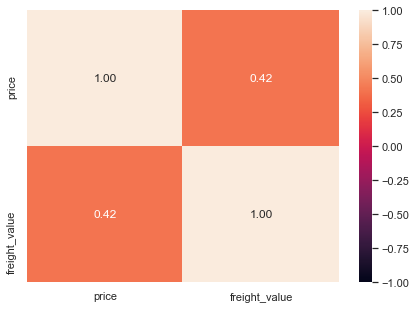

In [17]:
sb.jointplot(data = df, x = "price", y = "freight_value", height = 8)
print()

f = plt.figure(figsize=(7, 5))
sb.heatmap((df[["price","freight_value"]]).corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

Distance vs Freight value

<AxesSubplot:>

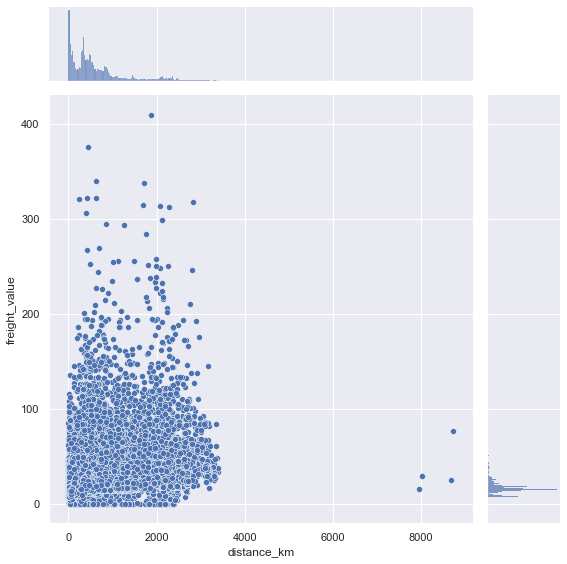

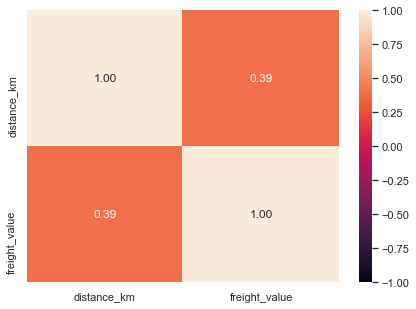

In [18]:
sb.jointplot(data = df, x = "distance_km", y = "freight_value", height = 8)
print()

f = plt.figure(figsize=(7, 5))
sb.heatmap((df[["distance_km","freight_value"]]).corr(), vmin = -1, vmax = 1, annot = True, fmt=".2f")

In [19]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,105074,105075,105076,105077,105078,105079,105080,105081,105082,105083
order_id,e481f51cbdc54678b7cc49136f2d6af7,53cdb2fc8bc7dce0b6741e2150273451,47770eb9100c2d0c44946d9cf07ec65d,949d5b44dbf5de918fe9c16f97b45f8a,ad21c59c0840e6cb83a9ceb5573f8159,a4591c265e18cb1dcee52889e2d8acc3,6514b8ad8028c9f2cc2374ded245783f,76c6e866289321a7c93b82b54852dc33,e69bfb5eb88e0ed6a785585b27e16dbf,e6ce16cb79ec1d90b1da9085a6118aeb,...,9115830be804184b91f5c00f6f49f92d,9115830be804184b91f5c00f6f49f92d,aa04ef5214580b06b10e2a378300db44,880675dff2150932f1601e1c07eadeeb,9c5dedf39a927c1b2549525ed64a053c,63943bddc261676b46f01ca7ac2f7bd8,83c1379a015df1e13d02aae0204711ab,11c177c8e97725db2631073c19f07b62,11c177c8e97725db2631073c19f07b62,66dea50a8b16d9b4dee7af250b4be1a5
customer_id,9ef432eb6251297304e76186b10a928d,b0830fb4747a6c6d20dea0b8c802d7ef,41ce2a54c0b03bf3443c3d931a367089,f88197465ea7920adcdbec7375364d82,8ab97904e6daea8866dbdbc4fb7aad2c,503740e9ca751ccdda7ba28e9ab8f608,9bdf08b4b3b52b5526ff42d37d47f222,f54a9f0e6b351c431402b8461ea51999,31ad1d1b63eb9962463f764d4e6e0c9d,494dded5b201313c64ed7f100595b95c,...,da2124f134f5dfbce9d06f29bdb6c308,da2124f134f5dfbce9d06f29bdb6c308,f01a6bfcc730456317e4081fe0c9940e,47cd45a6ac7b9fb16537df2ccffeb5ac,39bd1228ee8140590ac3aca26f2dfe00,1fca14ff2861355f6e5f14306ff977a7,1aa71eb042121263aafbe80c1b562c9c,b331b74b18dc79bcdf6532d51e1637c1,b331b74b18dc79bcdf6532d51e1637c1,edb027a75a1449115f6b43211ae02a24
order_status,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,...,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered
order_purchase_timestamp,2017-10-02 10:56:33,2018-07-24 20:41:37,2018-08-08 08:38:49,2017-11-18 19:28:06,2018-02-13 21:18:39,2017-07-09 21:57:05,2017-05-16 13:10:30,2017-01-23 18:29:09,2017-07-29 11:55:02,2017-05-16 19:41:10,...,2017-10-04 19:57:37,2017-10-04 19:57:37,2017-01-27 00:30:03,2017-02-23 09:05:12,2017-03-09 09:54:05,2018-02-06 12:58:58,2017-08-27 14:46:43,2018-01-08 21:28:27,2018-01-08 21:28:27,2018-03-08 20:57:30
order_delivered_carrier_date,2017-10-04 19:55:00,2018-07-26 14:31:00,2018-08-08 13:50:00,2017-11-22 13:39:59,2018-02-14 19:46:34,2017-07-11 14:58:04,2017-05-22 10:07:46,2017-01-26 14:16:31,2017-08-10 19:45:24,2017-05-18 11:40:40,...,2017-10-05 16:52:52,2017-10-05 16:52:52,2017-01-30 11:40:16,2017-03-01 10:22:52,2017-03-10 11:18:03,2018-02-07 23:22:42,2017-08-28 20:52:26,2018-01-12 15:35:03,2018-01-12 15:35:03,2018-03-09 22:11:59
order_delivered_customer_date,2017-10-10 21:25:13,2018-08-07 15:27:45,2018-08-17 18:06:29,2017-12-02 00:28:42,2018-02-16 18:17:02,2017-07-26 10:57:55,2017-05-26 12:55:51,2017-02-02 14:08:10,2017-08-16 17:14:30,2017-05-29 11:18:31,...,2017-10-20 20:25:45,2017-10-20 20:25:45,2017-02-07 13:15:25,2017-03-06 11:08:08,2017-03-17 15:08:01,2018-02-28 17:37:56,2017-09-21 11:24:17,2018-01-25 23:32:54,2018-01-25 23:32:54,2018-03-16 13:08:30
order_estimated_delivery_date,2017-10-18 00:00:00,2018-08-13 00:00:00,2018-09-04 00:00:00,2017-12-15 00:00:00,2018-02-26 00:00:00,2017-08-01 00:00:00,2017-06-07 00:00:00,2017-03-06 00:00:00,2017-08-23 00:00:00,2017-06-07 00:00:00,...,2017-11-07 00:00:00,2017-11-07 00:00:00,2017-03-17 00:00:00,2017-03-22 00:00:00,2017-03-28 00:00:00,2018-03-02 00:00:00,2017-09-27 00:00:00,2018-02-15 00:00:00,2018-02-15 00:00:00,2018-04-03 00:00:00
customer_zip_code_prefix,3149,47813,75265,59296,9195,86320,26525,99655,18075,20780,...,78048,78048,35502,5127,12209,11722,45920,28685,28685,83750
customer_city,sao paulo,barreiras,vianopolis,sao goncalo do amarante,santo andre,congonhinhas,nilopolis,faxinalzinho,sorocaba,rio de janeiro,...,cuiaba,cuiaba,divinopolis,sao paulo,sao jose dos campos,praia grande,nova vicosa,japuiba,japuiba,lapa
customer_state,SP,BA,GO,RN,SP,PR,RJ,RS,SP,RJ,...,MT,MT,MG,SP,SP,SP,BA,RJ,RJ,PR


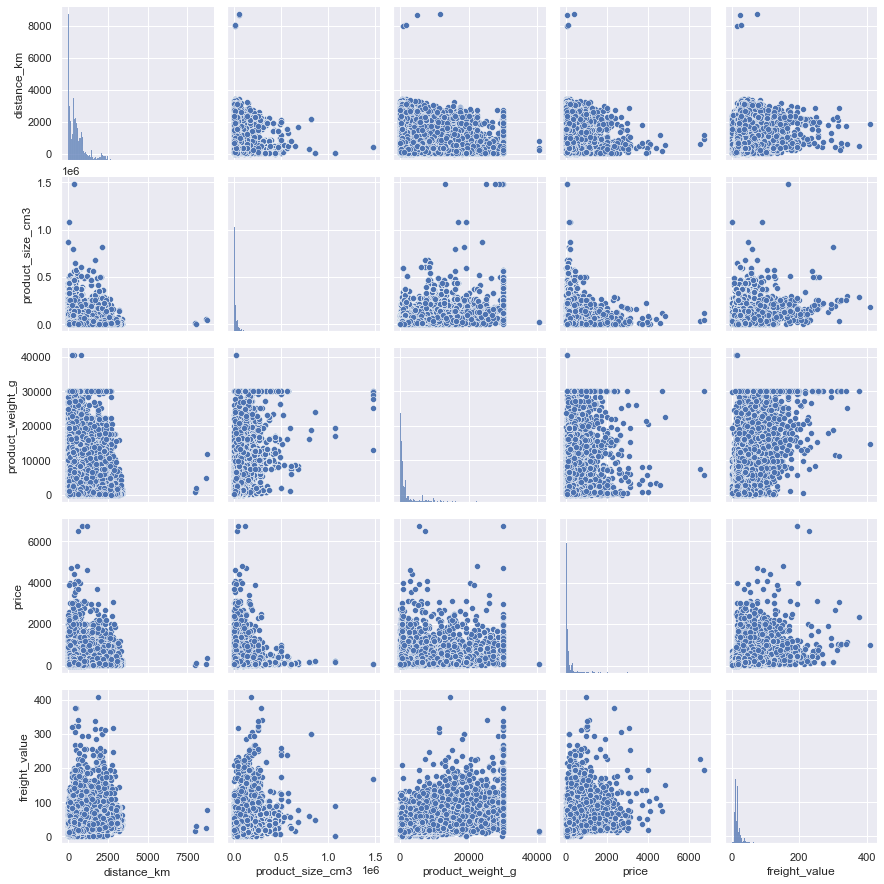

In [20]:
sb.pairplot(data = pd.DataFrame(df[['distance_km', 'product_size_cm3', 'product_weight_g', 'price', 'freight_value']]))

#### Looking for states that has the highest number of customers in Brazil

In [21]:
states_df = pd.DataFrame(df["customer_state"])
states_df = states_df.drop_duplicates()
states_df = states_df.reset_index(drop = True)

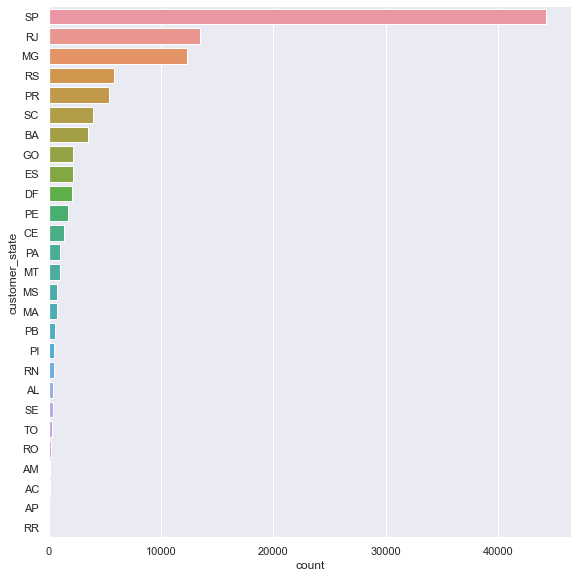

In [22]:

    
sb.catplot(y = df["customer_state"], data = df, kind = "count",
           order =  df["customer_state"].value_counts().index, height = 8)

### To reduce the skewness of our data, we are removing the outliers here:
1. Find the Interquartile range of data
2. Remove the outliers, which is outside of the whiskers


In [23]:
data = df['freight_value']

print("Previous skewness:", df['freight_value'].skew())
median = np.median(df['freight_value'])
upper_quartile = np.percentile(df['freight_value'], 75)
lower_quartile = np.percentile(df['freight_value'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()

print("freight_value of upper whisker: ", upper_whisker)
print("freight_value of lower whisker: ", lower_whisker)

df['freight_value'] = np.where(df['freight_value'] > upper_whisker, upper_whisker,df['freight_value'])
print("After removing the outliers:", df['freight_value'].skew())

Previous skewness: 5.745459410993045
freight_value of upper whisker:  33.2
freight_value of lower whisker:  1.09
After removing the outliers: 0.7112767912541296


In [24]:
SP_df = df[df['customer_state'] == 'SP']
MG_df = df[df['customer_state'] == 'MG']
RJ_df = df[df['customer_state'] == 'RJ']

top3 = pd.DataFrame([]) 
for var in [SP_df, MG_df, RJ_df]:
     top3 = top3.append(var)

top3=top3.reset_index(drop = True)
top3

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,distance_km,wait_time,product_size_cm3
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,...,8.0,13.0,9350,maua,SP,-23.680114,-46.452454,18.063837,8,1976.0
1,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9195,santo andre,SP,...,15.0,15.0,8752,mogi das cruzes,SP,-23.551707,-46.260979,30.174037,2,11475.0
2,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23,18075,sorocaba,SP,...,41.0,42.0,8577,itaquaquecetuba,SP,-23.482623,-46.374490,111.517726,18,72324.0
3,34513ce0c4fab462a55830c0989c7edb,7711cf624183d843aafe81855097bc37,delivered,2017-07-13 19:58:11,2017-07-14 18:43:29,2017-07-19 14:04:48,2017-08-08,4278,sao paulo,SP,...,21.0,21.0,90230,porto alegre,RS,-30.007312,-51.194222,844.977223,5,9261.0
4,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,4812,sao paulo,SP,...,10.0,16.0,14940,ibitinga,SP,-21.766477,-48.831547,308.455514,4,2560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70158,33baefa752f2d98a008d4330d306d3db,8b764335e86e1a8f8d3db9f119e03a79,delivered,2017-04-23 14:47:39,2017-04-25 13:24:03,2017-05-05 13:26:31,2017-05-15,20550,rio de janeiro,RJ,...,2.0,20.0,5849,sao paulo,SP,-23.651115,-46.755211,369.415256,11,640.0
70159,226dda5620db063cd962833766480273,b3e43e654b4d35baf3840feca1135f85,delivered,2017-07-18 12:42:28,2017-07-19 16:44:48,2017-07-28 18:55:50,2017-08-11,21331,rio de janeiro,RJ,...,2.0,11.0,89041,blumenau,SC,-26.911411,-49.111436,733.321372,10,352.0
70160,f6f9344efc918f1e00ab84c014aa21d7,166478efeed4f9a861164b4ff5acfe8b,delivered,2017-05-20 11:43:49,2017-05-25 14:33:53,2017-06-06 16:10:52,2017-06-21,21741,rio de janeiro,RJ,...,56.0,60.0,36500,uba,MG,-21.125743,-42.922605,201.898741,17,201600.0
70161,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,28685,japuiba,RJ,...,20.0,20.0,37175,ilicinea,MG,-20.944706,-45.827098,370.146853,17,16000.0


### Machine Learning - Two techniques

#### Random Forest Regression

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean/average prediction (regression) of the individual trees.

In [25]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score

target_col = ['freight_value']
feature_col = ['price','distance_km','product_size_cm3', 'product_weight_g']
all_col = target_col + feature_col
df[all_col] = df[all_col].applymap(np.int64)

train, test = train_test_split(top3, test_size = 0.2, random_state = 176)

rf = RandomForestRegressor(max_depth=30,n_estimators=10)
rf.fit(train[feature_col].values, train['freight_value'].values)

y_pred = rf.predict(test[feature_col].values)
r2 = r2_score(y_pred, test[target_col].values)
print('R-squared: {}'.format(r2))

importance =  rf.feature_importances_
importance = pd.DataFrame(importance, index=feature_col, columns=['importance'])
print('Feature importance:\n {}'.format(importance))

R-squared: 0.698704158340488
Feature importance:
                   importance
price               0.114100
distance_km         0.350441
product_size_cm3    0.090899
product_weight_g    0.444560


#### Determine the importance of each features



No handles with labels found to put in legend.


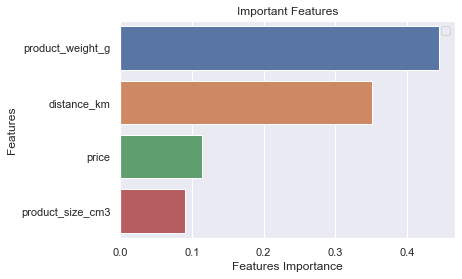

In [26]:
importance = pd.Series(rf.feature_importances_,index=feature_col).sort_values(ascending=False)
sb.barplot(x=importance, y=importance.index)
plt.xlabel('Features Importance')
plt.ylabel('Features')
plt.title("Important Features")
plt.legend()
plt.show()

#### To reduce the tree size for easier visualization, we limit the max_depth as 3 for our random forest regressor

In [27]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score

target_col = ['freight_value']
feature_col = ['price','distance_km','product_size_cm3', 'product_weight_g']
all_col = target_col + feature_col
df[all_col] = df[all_col].applymap(np.int64)

train, test = train_test_split(top3, test_size = 0.2, random_state = 176)

rf = RandomForestRegressor(max_depth=3,n_estimators=10)
rf.fit(train[feature_col].values, train['freight_value'].values)

y_pred = rf.predict(test[feature_col].values)
# r2 = r2_score(y_pred, test[target_col].values)
# print('R-squared: {}'.format(r2))

# importance =  rf.feature_importances_
# importance = pd.DataFrame(importance, index=feature_col, columns=['importance'])
# print('Feature importance:\n {}'.format(importance))

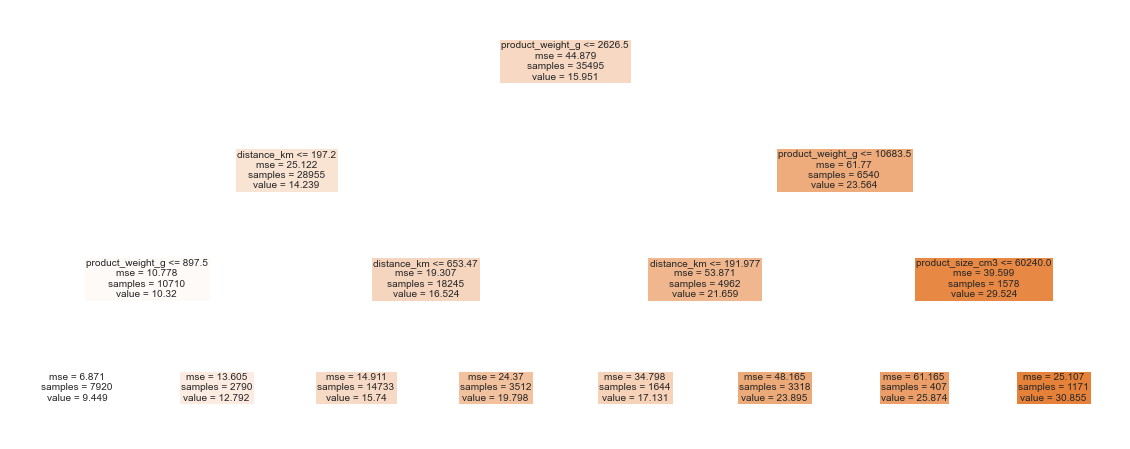

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
#rom dtreeviz.trees import dtreeviz # will be used for tree visualization
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (10, 5)})
plt.rcParams.update({'font.size': 20})


plt.figure(figsize=(20,8))
_ = tree.plot_tree(rf.estimators_[0], feature_names=train[feature_col].columns, filled=True)

### kNN

In [29]:
data = top3['product_weight_g']

median = np.median(top3['product_weight_g'])
upper_quartile = np.percentile(top3['product_weight_g'], 75)
lower_quartile = np.percentile(top3['product_weight_g'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()

print("product_weight_g: ", upper_whisker)
print("product_weight_g: ", lower_whisker)

top3['product_weight_g'] = np.where(top3['product_weight_g'] > upper_whisker, upper_whisker,top3['product_weight_g'])
top3['product_weight_g'].skew()

product_weight_g:  4050.0
product_weight_g:  0.0


1.14702834978636

In [30]:
data = top3['freight_value']

median = np.median(top3['freight_value'])
upper_quartile = np.percentile(top3['freight_value'], 75)
lower_quartile = np.percentile(top3['freight_value'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
lower_whisker = data[data>=lower_quartile-1.5*iqr].min()

print("freight_value: ", upper_whisker)
print("freight_value: ", lower_whisker)

top3['freight_value'] = np.where(top3['freight_value'] > upper_whisker, upper_whisker,top3['freight_value'])
top3['freight_value'].skew()

freight_value:  27.99
freight_value:  2.2


0.5599140415104016

In [31]:
freight_cat = ["{0} - {1}".format(i, i + 9) for i in range(1, 40, 10)]
top3["freight_cat"] = pd.cut(top3.freight_value, range(1, 45, 10), right=False, labels=freight_cat)

weight_cat = ["{0} - {1}".format(i, i + 1000) for i in range(1, 4995, 1000)]
top3["weight_cat"] = pd.cut(top3.product_weight_g, range(0, 5005, 1000), right=False, labels=weight_cat)

In [32]:
top3['freight_cat'].isnull().sum() 
top3.loc[top3['freight_cat'].isnull()].T

top3 = top3[top3.freight_cat.notnull()] # remove freight value == 0 (outliers)
top3=top3.reset_index(drop = True)

In [33]:
top3["weight_cat"].value_counts()

1 - 1001       41301
1001 - 2001    12694
4001 - 5001    10108
2001 - 3001     3957
3001 - 4001     1832
Name: weight_cat, dtype: int64

In [34]:
weight_encode = {'weight_cat': {'1 - 1000': 0, '1001 - 2000': 1, '2001 - 3000': 2, '3001 - 4000':3, '4001 - 5000':4}}

top3 = top3.replace(weight_encode)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(top3['product_weight_g']), pd.DataFrame(top3['freight_cat']), test_size = 0.2, random_state=22)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.ravel(y_train)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=50)
classifier.fit(X_train, y_train)
                          
                          
y_pred = classifier.predict(X_test)

# from mlxtend.plotting import plot_decision_regions
# # Plotting decision region
# plot_decision_regions(X_train, y_train.astype(np.int64), clf=classifier, legend=2)
# # Adding axes annotations
# plt.xlabel('product_weight_g')
# plt.ylabel('freight_cat')
# plt.show()

              precision    recall  f1-score   support

      1 - 10       0.48      0.02      0.04      2927
     11 - 20       0.68      0.90      0.77      8712
     21 - 30       0.62      0.59      0.60      2340

    accuracy                           0.67     13979
   macro avg       0.59      0.50      0.47     13979
weighted avg       0.63      0.67      0.59     13979

Accuracy: 0.6659989984977466


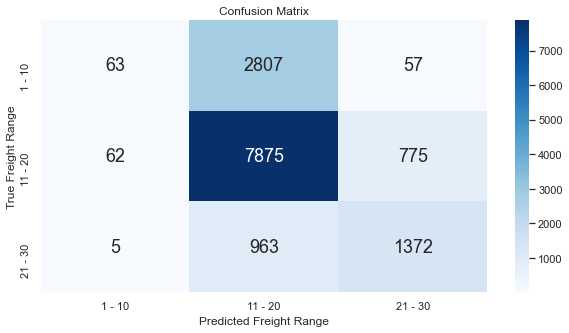

In [36]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

labels = ['1 - 10', '11 - 20', '21 - 30']

#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels))
print(classification_report(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

ax= plt.subplot()
sb.heatmap(confusion_matrix(y_test, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, cmap='Blues')

ax.set_xlabel('Predicted Freight Range'); ax.set_ylabel('True Freight Range'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1 - 10', '11 - 20', '21 - 30']); ax.yaxis.set_ticklabels(['1 - 10', '11 - 20', '21 - 30']);

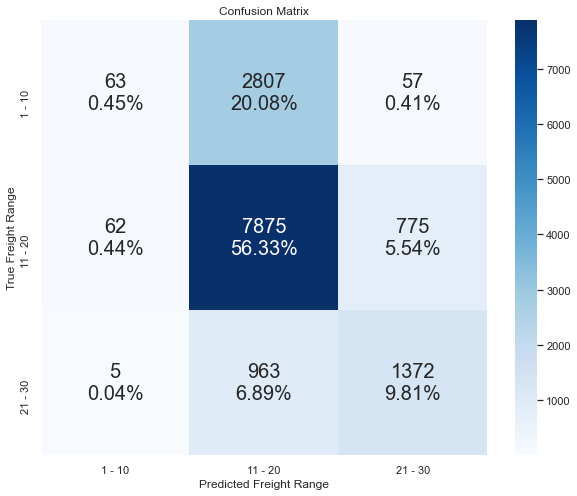

In [37]:
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix(y_test, y_pred).flatten()/np.sum(confusion_matrix(y_test, y_pred))]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

f = plt.figure(figsize=(10,8))
ax = plt.subplot()
sb.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='',annot_kws={"size": 20}, cmap='Blues')
ax.set_xlabel('Predicted Freight Range'); ax.set_ylabel('True Freight Range');
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['1 - 10', '11 - 20', '21 - 30']); ax.yaxis.set_ticklabels(['1 - 10', '11 - 20', '21 - 30']);